In [1]:
import datetime
import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
#import qlat as q
from scipy.optimize import curve_fit
from scipy.integrate import quad_vec
import gc

In [2]:
from importlib import reload

In [3]:
#import warnings
#warnings.filterwarnings("error")

In [4]:
import data
import ratios_fit
import jackknife as jk

In [5]:
try:
    del measurements
    gc.collect()
except:
    pass

Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.8
beta = 9.0
barrier_strength = 10.0
t_full = "*"
dt = 0.2
#
version = "3-2"
date = "*" #datetime.datetime.now().date()

cutoff = 10000
block_size = 10000

measurements = data.Data(cutoff, block_size)

M = "*"
L = "*"
t_FV = "*" #60
fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

measurements.load(f"output_data/measurements_{fileid}.bin")

#M = "1.0"
#L = "0.0"
#t_FV = "*" #65
#fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

#measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_1.0_L_0.128_tfull_5_tFV_65_2024-08-09_3-2.bin ...
# traj: 50000
Accept rate: 0.9653208382169735
... Loaded output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_1.0_L_0.128_tfull_5_tFV_65_*_3-2.bin
Loading output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_0.032_L_1.0_tfull_10_tFV_65_2024-08-09_3-2.bin ...
# traj: 50000
Accept rate: 0.9673014334328439
... Loaded output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_0.032_L_1.0_tfull_10_tFV_65_*_3-2.bin
Loading output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_1.0_L_0.032_tfull_5_tFV_65_2024-08-09_3-2.bin ...
# traj: 50000
Accept rate: 0.9639880071763223
... Loaded output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_1.0_L_0.032_tfull_5_tFV_65_*_3-2.bin
Loading output_data/measurements_1x100_alpha_0.8_beta_9.0_dt_0.2_bar_10.0_M_0.512_L_1.0_tfull_10_tFV_65_2024-08-09_3-2.bin ...
# traj:

[1.4565037223946684, 1.2359331486634053, 1.1464271385941396, 1.0792806064609626, 1.0306703131756376, 0.9932358857830483, 0.957420631003853]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]
[85, 80, 75, 70, 65, 60, 50]
[1.4328696380836563, 1.2070162880791668, 1.1082889767743715, 1.0408408910287927, 0.9994820696491775, 0.9712031572735279, 0.9445305850999187]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]
[75, 70, 65, 60, 55, 50, 40]


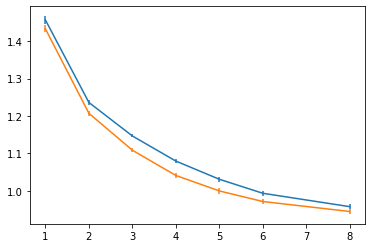

In [6]:
t_full1 = 5
t_full2 = 10

profile_tFV1  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full1}_tFV_*_*_*"
profile_tFV2  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full2}_tFV_*_*_*"
sfs1 = measurements.get_sfs_list(list(measurements.delta_actions_t_FV), profile_tFV1)
sfs2 = measurements.get_sfs_list(list(measurements.delta_actions_t_FV), profile_tFV2)

#t_FVs1, ratios1, dS_errs1 = measurements.plot_exp_Ebar_blocks("tFV", sfs=sfs1, get_x=lambda sf: int(measurements.get_param(sf,"tFV")), filter_x=lambda x: x<1)
#t_FVs2, ratios2, dS_errs2 = measurements.plot_exp_Ebar_blocks("tFV", sfs=sfs2, get_x=lambda sf: int(measurements.get_param(sf,"tFV")), filter_x=lambda x: x<1)

t_TVs1, ratios1, dS_errs1 = measurements.plot_exp_Ebar_blocks("tTV", sfs=sfs1, get_x=lambda sf: int(measurements.get_param(sf,"tTV"))*dt, filter_x=lambda x: x<1)
t_TVs2, ratios2, dS_errs2 = measurements.plot_exp_Ebar_blocks("tTV", sfs=sfs2, get_x=lambda sf: int(measurements.get_param(sf,"tTV"))*dt, filter_x=lambda x: x<1)

sfs1.sort(key=lambda x: measurements.get_t_TV(x))
sfs2.sort(key=lambda x: measurements.get_t_TV(x))
t_FVs1 = [int(measurements.get_param(sf, "tFV")) for sf in sfs1]
t_FVs2 = [int(measurements.get_param(sf, "tFV")) for sf in sfs2]

print(ratios1)
print(t_TVs1)
print(t_FVs1)
print(ratios2)
print(t_TVs2)
print(t_FVs2)

Correction factor: 0.032765135158606955
E0: 4.062469278405248, sigma: 0.9697402703865081
Covariance: [0.24811473 0.04729856]


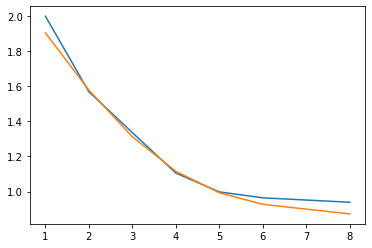

In [8]:
fit = ratios_fit.GaussianFitNoBounds(dt)
opt, cov = fit.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<2 or t>4)
fit.plot_results(t_TVs1, ratios1, opt, cov, 2)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
[1.3340407990298782, 1.1423015145828417, 1.0552573252852135, 1.0062215129011554, 0.9800205345846384, 0.962441763102642, 0.9523724169144799, 0.9450090413053687]
[0.008685046737181306, 0.005908279111006949, 0.0041464722591993235, 0.0043289668728238445, 0.004740359009284514, 0.004923663343367656, 0.004442918482020327, 0.005140156785675699]
Correction factor: 0.7144701587664766
E_FV: 0.4483866016247697, E0: 2.301692012576292, sigma: 1.039687817985991
Covariance: [0.01051685 0.05649757 0.02779713]


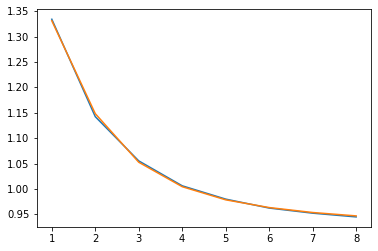

In [27]:
fit = ratios_fit.GaussianFit(dt)
#t_start = fit.choose_start(t_TVs, ratios, dS_errs)
print(t_TVs1)
print(ratios1)
print(dS_errs1)
opt, cov = fit.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<0 or t>9)
fit.plot_results(t_TVs1, ratios1, opt, cov, 6)

#opt, cov = fit.get_fit_params(t_TVs2, ratios2, dS_errs2, filter_x=lambda t: t<0 or t>8)
#fit.plot_results(t_TVs2, ratios2, opt, cov, 4)

fit_g = fit
opt_g = opt

Correction factor: 0.5666586956132816
start_time: 2.9822715144425973, E_FV: 0.5753708198037686, n: 1.696207147861173e-07
Covariance: [8.16845101e+01 3.65078207e-02 3.69157218e+04 2.76975359e-05]


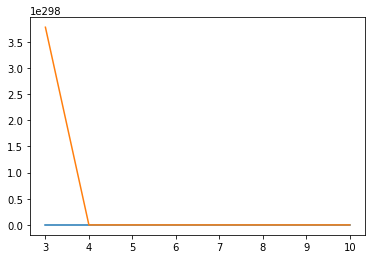

In [74]:
fit = ratios_fit.PowerFit2(dt)
#opt, cov = fit.get_fit_params(t_TVs1, ratios1, dS_errs1, filter_x=lambda t: t<0 or t>8)
#fit.plot_results(t_TVs1, ratios1, opt, cov, 8)

opt, cov = fit.get_fit_params(t_TVs2, ratios2, dS_errs2, filter_x=lambda t: t<4 or t>8)
fit.plot_results(t_TVs2, ratios2, opt, cov, 4)

fit_power = fit
opt_power = opt

In [86]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_*_*_*"

sfs = measurements.get_sfs_list(list(measurements.delta_actions_t_FV), profile_tFV)
sfs.sort(key=lambda x: float(measurements.get_param(x, "tTV")))

dS_blocks = []
errs = []
ts = []
for sf in sfs:
    t = measurements.get_t_TV(sf)*dt
    if(t>0):
        dS_blocks.append(measurements.get_exp_Ebar_blocks(sf))
        errs.append(jk.get_errors_from_blocks(np.mean(dS_blocks[-1]),dS_blocks[-1])[1])
        ts.append(t)
measurements.fit_ratios(np.mean(dS_blocks,axis=1), errs, ts, 2, dt)

0.01805762619970402

In [ ]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full1}_tFV_*_*_*"
pfit_from_mean, power_blocks = measurements.get_fit_ratios_blocks(profile_tFV, 7.0, start=0, stop=9, fitobject=ratios_fit.PowerFit2)

In [ ]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full1}_tFV_*_*_{version}.bin"
gfit_from_mean, gaus_blocks = measurements.get_fit_ratios_blocks(profile_tFV, 6.0, start=5, stop=9)

In [111]:
#jk.get_errors_from_blocks(np.mean(blocks), blocks)
print(jk.get_errors_from_blocks(gfit_from_mean, gaus_blocks))
#print(jk.get_errors_from_blocks(pfit_from_mean, power_blocks))

[0.5556694442825074, 0.010022371602001008]


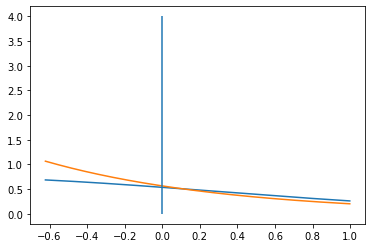

In [76]:
t = 4.0
E = np.arange(-opt_g[0],1,0.01)
plt.plot(E, [fit_g.integrand(E[i],np.array([t]),fit_g.start_time,opt_g[0],opt_g[1],opt_g[2])[0] for i in range(len(E))]/fit_g.Rt(np.array([t]),fit_g.start_time,opt_g[0],opt_g[1],opt_g[2]))

plt.plot(E, [fit_power.integrand(E[i],np.array([t]),*opt_power)[0] for i in range(len(E))]/fit_power.Rt(np.array([t]),*opt_power))

plt.vlines([0.0], 0.0, 4.0)

In [8]:
profile1  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full1}_tFV_60_*_{version}.bin"

Ms = [0.0, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]

#profile_tFV = measurements.replace_params(profile,["M","L","tFV"],[[1.0,0.0,"*"]])[0]
#dt = float(measurements.get_param(profile, "dt"))
#fit_time = int(measurements.get_param(profile,"tTV"))*dt
#print(fit_time)
#measurements.get_fit_ratios_blocks(profile_tFV, fit_time, start=0, stop=100)

gamma_mean1, gamma_blocks1 = measurements.calc_gamma_blocks(Ms, Ls, 0, 9, profile1)
print(f"gamma 1: {jk.get_errors_from_blocks(gamma_mean1, gamma_blocks1)}")

Based on mean, ratios fit is: 1.072826853405831
Correction factor estimated: 1.072826853405831
gamma 1: [0.0035563868744202956, 0.00039079981833516563]


In [9]:
profile2  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full2}_tFV_60_*_{version}.bin"
gamma_mean2, gamma_blocks2 = measurements.calc_gamma_blocks(Ms, Ls, 0, 8, profile2)
print(f"gamma 2: {jk.get_errors_from_blocks(gamma_mean2, gamma_blocks2)}")

Based on mean, ratios fit is: 0.8765320987814341
Correction factor estimated: 0.8765320987814341
gamma 2: [0.0016126991978214107, 0.00012708642395677428]


In [10]:
measurements.calc_gamma_sub_w_errors(gamma_blocks1, t_full1, gamma_blocks2, t_full2)

[0.00042005343205539215, 0.0001868504186524933]

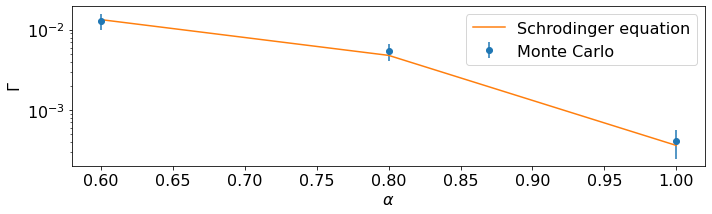

In [46]:
alphas = []
betas = []
gammas = []
gamma_errs = []
gamma_res = []

#alphas.append(0.6)
#betas.append(20.0)
#gammas.append(1.308e-5)
#gamma_errs.append(0.3422e-5)
#gamma_res.append(0.7321e-5)

#alphas.append(0.8)
#betas.append(20.0)
#gammas.append(6.2295e-7)
#gamma_errs.append(1.288e-7)
#gamma_res.append(4.8154e-7)

alphas.append(0.6)
betas.append(9.0)
gammas.append(1.287e-2)
gamma_errs.append(0.3037e-2)
gamma_res.append(1.338e-2)

alphas.append(0.8)
betas.append(9.0)
gammas.append(5.365e-3)
gamma_errs.append(1.285e-3)
gamma_res.append(4.7977e-3)

alphas.append(1.0)
betas.append(9.0)
gammas.append(4.074e-4)
gamma_errs.append(1.59e-4)
gamma_res.append(3.62e-4)

#alphas.append(1.0)
#betas.append(10.0)
#gammas.append(1.3733e-4)
#gamma_errs.append(4.288e-5)
#gamma_res.append(1.1105e-4)

#alphas.append(1.0)
#betas.append(12.0)
#gammas.append(1.1470e-5)
#gamma_errs.append(3.193e-6)
#gamma_res.append(9.8049e-06)

#alphas.append(1.0)
#betas.append(14.0)
#gammas.append(7.8246e-7)
#gamma_errs.append(2.5058e-7)
#gamma_res.append(8.2673e-7)

#alphas.append(1.0)
#betas.append(16.0)
#gammas.append(6.9751e-8)
#gamma_errs.append(3.04516e-8)
#gamma_res.append(6.6858e-8)

#alphas.append(1.0)
#betas.append(18.0)
#gammas.append(5.7618e-9)
#gamma_errs.append(2.1645e-9)
#gamma_res.append(5.3352e-09)

#alphas.append(1.0)
#betas.append(20.0)
#gammas.append(3.2999e-10)
#gamma_errs.append(1.166e-10)
#gamma_res.append(4.1945e-10)

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
fig,ax = plt.subplots()
#ax.set_xlim([-1,5])
#ax.set_ylim([-0.1,4])
#ax.set_xlabel("x")
#ax.set_ylabel("V")
fig.set_figwidth(10)
fig.set_figheight(3)

ax.errorbar(alphas, gammas, yerr=gamma_errs, fmt="o", label="Monte Carlo")
ax.plot(alphas,gamma_res, label="Schrodinger equation")

ax.legend()
plt.tight_layout()

ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\Gamma$")
ax.set_yscale('log')

fig.savefig("results_alpha.pdf", transparent=True)

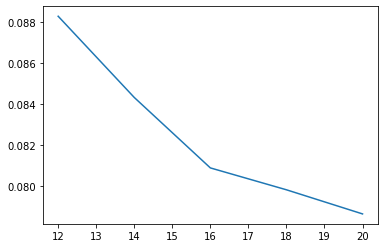

In [77]:
plt.plot(betas[2:], np.divide(gamma_res[2:],gamma_res[1:-1]))

# Changing $t_\text{full}$

In [15]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 1.0
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.0}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 10000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

NameError: name 'Data' is not defined

In [16]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
profile_ML = f"output_data/measurements_{fileid}.bin"

ml_blocks = measurements.get_M_L_blocks(Ms, Ls, profile_ML)
R_blocks = jk.super_jackknife_combine_blocks(ml_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(np.mean(R_blocks), R_blocks)

NameError: name 'measurements' is not defined

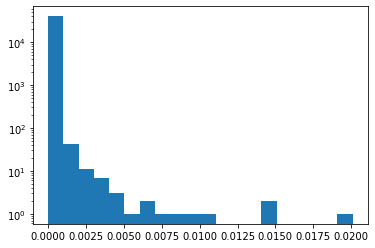

In [86]:
sfs = measurements.replace_params(profile_ML, ["M", "L"], [[0.128, 1.0]])
for sf in sfs:
    a = np.exp(measurements.delta_actions_M[sf][f"0.256"][measurements.cutoff:])
    plt.hist(a[:], bins=20)
    plt.yscale("log")

[6.40821350e-06 1.68212885e+00]


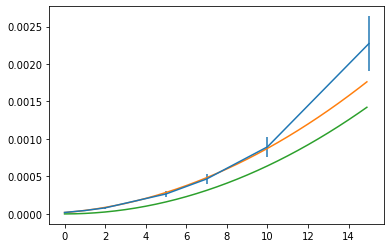

In [19]:
t = [0, 1, 2, 5, 7, 10, 15]
R = [1.9325564090891424e-05, 4.507398632625518e-05, 8.074689508988359e-05, 0.0002662934489756581, 0.00046580201801283013, 0.0008946857327069169, 0.0022725578364517873]
R_err = [2.6651406798190626e-06, 6.316515688423676e-06, 1.1390259997472873e-05, 4.0396227507911365e-05, 6.737820785562193e-05, 0.00013266703652616086, 0.0003646535178961716]

#f=lambda t, A, B: A*np.power(t+B,2)
f=lambda t, A, B: A*np.power(t+B,2)
opt, cov = curve_fit(f, t[:10], R[:10], sigma=R_err[:10])

end = 8
plt.errorbar(t[:end], R[:end], yerr=R_err[:end])

t=np.arange(0,15, 0.1)
fit = lambda t: f(t,opt[0],opt[1])
plt.plot(t, fit(t))
corrected_fit = lambda t: f(t,opt[0],0)
plt.plot(t, corrected_fit(t))
print(opt)
#print(opt[0], 2*opt[0]*opt[1], opt[0]*opt[1]**2)

# Calculating the Decay Rate

In [49]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 9.0
barrier_strength = 1000.0
M = "*"
L = "*"
t_full = 10
t_FV = "*" #65
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9367531607281055
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.512_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9085975642438758
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.512_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.004_tfull_10_tFV_68_2024-06-17_3-1.bin
# traj: 50000
Accept rate: 0.9269165070553488
Loaded output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.004_tfull_10_tFV_68_*_3-1.bin
Loading output_data/measurements_1x100_alpha_0.6_beta_9.0_dt_0.2_bar_1000.0_M_1.0_L_0.0_tfull_10_tFV_45_2024-06-17_3-1.bin
# traj: 50000
Accept ra

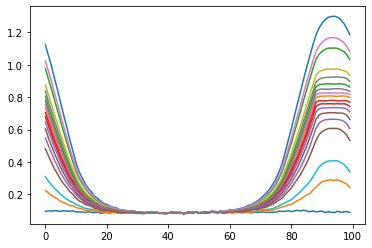

In [51]:
profile_tFV  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"

#profile_tFV = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_1.0_L_0.0_tfull_{t_full}_tFV_{t_FV}_*_{version}.bin"
tFV_ML = 68
profile_ML  = f"output_data/measurements_{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"
#profile_ML = f"output_data/measurements_{total_site[0]}x{total_site[3]}_lmbd_{0.01}_v0_{3.5}_alpha_{0.0}_m_{1.0}_dt_{dt}_bar_{barrier_strength}_M_*_L_*_tfull_{t_full}_tFV_{tFV_ML}_*_{version}.bin"

measurements.plot_mean_path(profile_ML)
#plt.legend()
#fig = plt.gcf()
#fig.set_size_inches(20, 10)
plt.show()

/home/joshua/Joshua/School/Research/Qlattice/applications/false-vacuum-decay/data.py:212: RuntimeWarning: invalid value encountered in sqrt
  return ((bdiv1 - bdiv2) / dt_TV)**0.5
/home/joshua/.local/lib/python3.10/site-packages/numpy/core/_methods.py:45: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/joshua/.local/lib/python3.10/site-packages/numpy/core/_methods.py:41: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


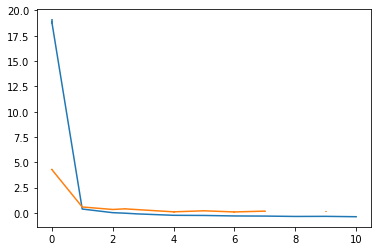

In [52]:
measurements.plot_Ebar_E_FV(profile_tFV)
measurements.plot_Ebar_slope(profile_tFV)

In [53]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
gamma, gamma_err = measurements.calc_gamma_w_errors(Ms, Ls, profile_ML, profile_tFV, der=0)
print(gamma, gamma_err)

Calculating dE with t_FV=68 and t_FV=70
Correction factor estimated: 1.1273113046885366
0.016202365077895055 0.002859537403734015


In [54]:
gammas_M_L = measurements.calc_gamma_M_L_errors(Ms,Ls,profile_ML, profile_tFV)

Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Correction factor estimated: 1.034296375372885
Calculating dE with t_FV=66 and t_FV=70
Cor

[0.01528374926308796, 0.015462075470953943, 0.015207928245689915, 0.015461961218334187, 0.015085841411594903, 0.015008587784271075, 0.015782012866831226, 0.014856305215676647, 0.015258563620151207, 0.015207208999101277, 0.015264291720866678, 0.014949848851131544, 0.015380373892633704, 0.01543557836101771, 0.015437636035639581, 0.01534780989292731]


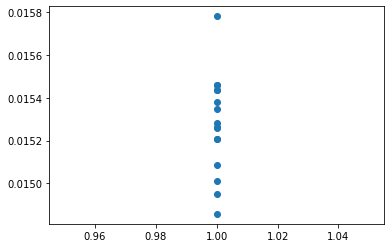

In [55]:
plt.scatter([1]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
print(gammas_M_L)

In [21]:
l_err, u_err = measurements.calc_gamma_dis_errors(Ms,Ls,profile_ML, profile_tFV)
print(l_err, u_err)

Calculating dE with t_FV=60 and t_FV=70
Calculating dE with t_FV=60 and t_FV=65
Calculating dE with t_FV=65 and t_FV=70
7.856115035859276e-05 9.032834088495457e-05


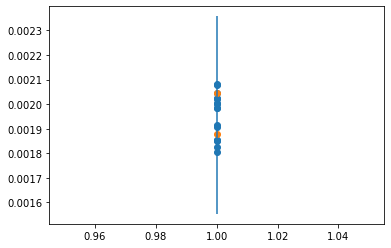

In [22]:
plt.errorbar([1.0], [gamma], [gamma_err])
plt.scatter([1.0]*len(gammas_M_L), [gammas_M_L[i] for i in range(len(gammas_M_L))])
plt.scatter([1.0]*2, [gamma+u_err, gamma-l_err])

In [ ]:
0.0018729202417479005, 0.000389280560521738
0.0020105263780584417, 0.0005082331894344297
0.002804109507570317, 0.0005700302060932646

**Systematic errors:**
- Discretization error in determining $\Delta E$ from the slope of $\bar{E}$
- Systematic bias when calculuting ratios

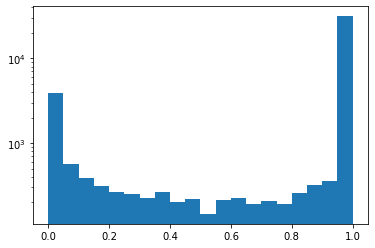

In [57]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.array(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]))
plt.hist(a[a>-15], bins=20)
plt.yscale("log")

2.4248795963573606

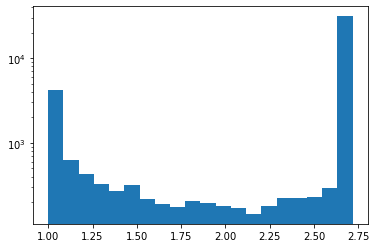

In [58]:
plt.hist(np.exp(a[a>-50]), bins=20)
plt.yscale("log")
np.mean(np.exp(a[a>-15]))

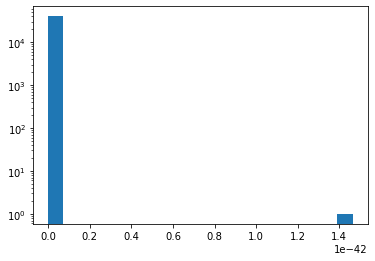

In [54]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
t_TV = measurements.get_t_TV(sf)
a = np.exp(measurements.delta_actions_M[sf][f"0.512"][measurements.cutoff:])
plt.hist(a[a<1e-1], bins=20)
plt.yscale("log")
#plt.xscale("log")

**Old code:**

In [13]:
sf = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
Ebar = measurements.get_Ebar_E_FV(sf)
print(Ebar)

[-0.07925521899146061, 0.0747078765790698]


In [14]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.24658002974604404, 0.06983637299327515]


In [15]:
sf1 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin"
sf2 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin"
delta_E = measurements.get_Ebar_slope(sf1, sf2)
print(delta_E)

[0.2883725302516306, 0.04876960693493655]


In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_1-1.bin"
da_blocks = measurements.get_M_L_blocks(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_blocks, len(Ms)-1)
blocks = jk.super_jackknife_combine_blocks(da_blocks, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.00029132200314709055, 5.222914895353905e-05]

In [16]:
measurements.calc_gamma(ratio, Ebar[0], delta_E[0], 5, 0.2)

0.002450739789529811

In [27]:
measurements.calc_gamma(corrected_fit(5), Ebar[0], delta_E[0], 5, 0.2)

0.0020455287419108114

# Calculating $\bar{E}$ and $\Delta E$

Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_75_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_65_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_70_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_85_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_55_*_1-1.bin
Loaded output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_80_*_1-1.bin


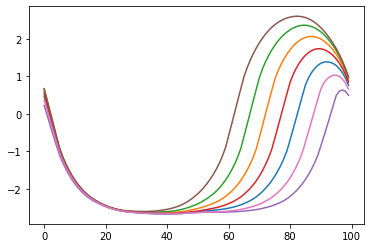

In [12]:
Nt = 100
total_site = [1,1,1,Nt]
lmbd = 0.01
v0 = 3.0
alpha = 0.0
barrier_strength = 100.0
M = "1.0"
L = "0.0"
t_full = "5"
t_FV = "*"
m_particle = 1.0
dt = 0.2
#
version = "1-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

measurements.plot_mean_path()
plt.show()

## TDSE Calculations for $\bar{E}$ and $\Delta E$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.42803769 0.35841281 0.29972513 0.24955727]


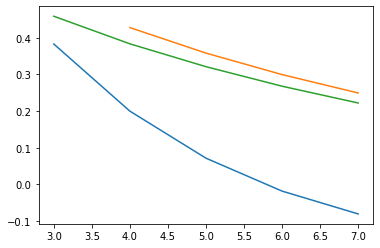

In [4]:
t_full_tdse = 1.0
t_total_tdse = 20.0
t_FV_tdse = [[7.5, 7.6, 6.4], 
             [7.0, 7.1, 6.9], 
             [6.5, 6.6, 6.4], 
             [6.0, 6.1, 5.9], 
             [5.5, 5.6, 5.4]]
t_FV_tdse = np.multiply(t_FV_tdse,2)
t_TV_tdse = [[1.5, 1.4, 1.6], 
             [2.0, 1.9, 2.1], 
             [2.5, 2.4, 2.6], 
             [3.0, 2.9, 3.1], 
             [3.5, 3.4, 3.6]]
t_TV_tdse = np.multiply(t_TV_tdse,2)
corr_tdse = [[8.248663373196439e-08, 8.905703783595409e-08, 7.704757642858247e-08],
             [6.309382431172544e-08, 6.566856939543131e-08, 6.097811910246092e-08],
             [5.599952880841047e-08, 5.680639177237058e-08, 5.543258059759522e-08],
             [5.51639432842981e-08, 5.4962332229197884e-08, 5.5525637075399806e-08],
             [5.8430364009058354e-08, 5.7496177293354066e-08, 5.9497150195223996e-08]]
corr0 = 0.0002828628961749551 # Correlation function when only H_FV is used

def plot_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse, E_tdse)
    print(E_tdse)

def plot_slope_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][j]/corr_tdse[i][0])/(t_TV_tdse[i][0]-t_TV_tdse[i][j]))
    plt.plot(E_t_TV_tdse[1:], (-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)
    print((-np.subtract(E_tdse[1:], E_tdse[:-1])/np.subtract(E_t_TV_tdse[1:],E_t_TV_tdse[:-1]))**0.5)

def plot_delta_E_tdse(j=1):
    E_t_TV_tdse = []
    E_tdse = []
    for i in range(len(corr_tdse)):
        E_t_TV_tdse.append(t_TV_tdse[i][0])
        E_tdse.append(np.log(corr_tdse[i][1]*corr_tdse[i][2]/corr_tdse[i][0]**2)**0.5/(t_TV_tdse[i][0]-t_TV_tdse[i][1]))
    plt.plot(E_t_TV_tdse, E_tdse)

plot_E_tdse()
plot_slope_tdse()
plot_delta_E_tdse()

In [14]:
R = 5.599952880841047e-08/corr0
print(f"R: {R}")
dE = 0.29972513
Ebar_m_E_FV = 0.07152787017714676

print(R*(2*np.pi)**0.5/dE * np.exp(-(Ebar_m_E_FV)**2/2/dE**2)/(5*0.2)**2)

R: 0.00019797410535517493
0.0016091937249886627


## Calculating $\bar{E}$

[0.38320387088209507, 0.19998760952050332, 0.07152787017714676, -0.018307282199245094, -0.08058611319964533]
[0.34106579050817015, 0.17053898362684042, 0.05087879121495884, -0.032676524498533574, -0.09046364573722997]


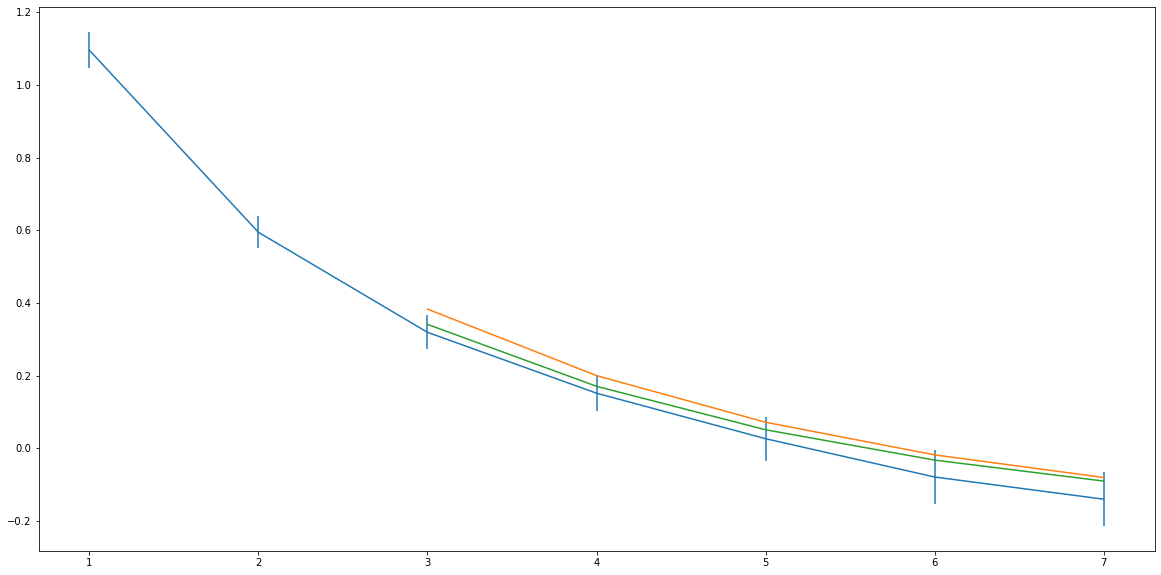

In [19]:
measurements.cutoff = 10000
measurements.block_size = 2000
measurements.plot_Ebar_E_FV(1)
#measurements.plot_Ebar_E_FV(2)
#measurements.plot_Ebar_E_FV(-2)
#measurements2.plot_Ebar_E_FV(-2)
plot_E_tdse()
plot_E_tdse(2)
#plt.xlim(8,42)
#plt.ylim(-0.7,0.7)

fig = plt.gcf()
fig.set_size_inches(20, 10)

## Calculating $\Delta E$

[0.42803769 0.35841281 0.29972513 0.24955727]


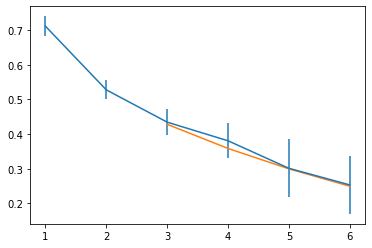

In [16]:
measurements.plot_Ebar_slope()
plot_slope_tdse()

## Analytic Calculation Based on Initial Ansatz

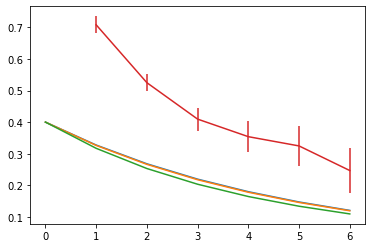

In [8]:
m_particle = 1.0
E0 = 0.4
Gamma = 0.0015
def E_dist(E,t):
    return 1/((E-E0)**2+Gamma**2/4.0)*np.exp(-E*t)

dE = 0.0001
Es=np.arange(0,2*E0,dE)
#plt.plot(Es, E_dist(Es,4.0))

def get_delta_E(t):
    return (np.sum(E_dist(Es,t)*Es**2)*dE)**0.5

def plot_delta_Es():
    dEs=[]
    for t in np.arange(0,7,1):
        dEs.append(get_delta_E(t))
    plt.plot(np.divide(dEs,2.5*dEs[0]))

plot_delta_Es()
Gamma = 0.015
plot_delta_Es()
Gamma = 0.15
plot_delta_Es()
measurements.plot_Ebar_slope()
#plot_half_slope_tdse()

## Obserable Distribution

[0.31928225666093996, 0.0466713256630312]
0.319282256660941


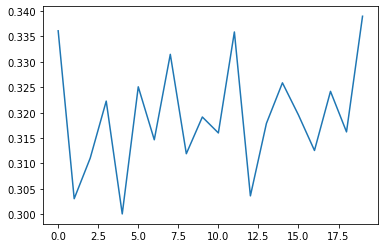

In [50]:
measurements.block_size = 2000
measurements.cutoff=10000

t_TV = measurements.get_t_TV(sf)
t_FV = int(measurements.get_param(sf,"tFV"))
dt = float(measurements.get_param(sf, "dt"))

blocks_TV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_TV[sf][f"{t_TV+1}"][measurements.cutoff:]), measurements.block_size)
blocks_FV = jk.get_jackknife_blocks(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:]), measurements.block_size)
bdiv = np.log(np.divide(blocks_FV,blocks_TV))/(dt*1)

#plt.plot(np.exp(measurements.delta_actions_t_FV[sf][f"{t_FV+1}"][measurements.cutoff:measurements.cutoff+100]))
plt.plot(bdiv[:])
print(jk.get_errors_from_blocks(np.mean(bdiv), bdiv))
print(np.mean(bdiv))

# Changing M and L

In [7]:
Nt = 100
total_site = [1,1,1,Nt]
alpha = 0.6
beta = 20.0
barrier_strength = 100.0
M = "*"
L = "*"
t_full = 5
t_FV = 60
dt = 0.2
#
version = "3-1"
date = "*" #datetime.datetime.now().date()

fileid = f"{total_site[0]}x{total_site[3]}_alpha_{alpha}_beta_{beta}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"

cutoff = 10000
block_size = 2000

measurements = Data(Nt, cutoff, block_size)
measurements.load(f"output_data/measurements_{fileid}.bin")

Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.016_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8608987733648119
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.064_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8559494699676661
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.8011887194299901
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.004_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7999942721396615
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.861121361658655
Loaded output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.016_tfull_5_tFV_60_*_3-1.bin
# traj: 50000
Accept rate: 0.7976642116857925
Loaded output_data/measurements_1x100_alp

In [27]:
#for M in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{round(M,5)}_L_{L}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

In [28]:
#M = 1.0
#for L in np.arange(0.0, 1.0, 0.001):
#    fileid = f"{total_site[0]}x{total_site[3]}_lmbd_{lmbd}_v0_{v0}_alpha_{alpha}_m_{m_particle}_dt_{dt}_bar_{barrier_strength}_M_{M}_L_{round(L,5)}_tfull_{t_full}_tFV_{t_FV}_{date}_{version}"
#    measurements.load(f"output_data/measurements_{fileid}.bin")

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for M=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.4988246853274199, 0.2551145494227235, 0.07178862495247165, 0.0075162482033356215, 0.00022261829123066128, 2.8987226378867073e-06, 1.5816597285929933e-08, 3.3774160802167156e-12, 3.7488426295116393e-19]
[0.0004957345099183301, 0.0005342017345603138, 0.0003320232066383379, 8.46324466526588e-05, 8.735223127772413e-06, 5.843690226122213e-07, 8.910705384460113e-09, 3.044653293256373e-12, 3.7342674707618433e-19]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_0.002_L_1.0_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.25509296248329716, 0.071776290700138, 0.007515961383716473, 0.0002232103571726112, 3.075316577618656e-06, 2.4261232021929398e-08, 1.2757965461543315e-11, 9.05542083534448e-18, 2.1610648244249003e-29]
[0.00025230

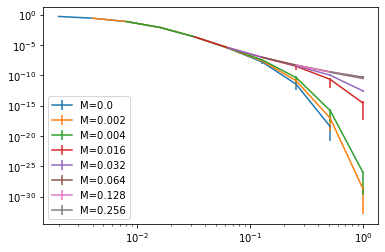

In [8]:
measurements.plot_expS_vs_M()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.0_tfull_5_tFV_60_*_3-1.bin
No previous factor found for L=0.0
[0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
[0.7034571107697758, 0.5071910841972777, 0.2797849925836887, 0.10159331755055567, 0.021419161754138993, 0.0029268374783120842, 0.0004352897090345533, 8.602142287919883e-05, 1.505623455269142e-05]
[0.0012220448315693997, 0.0016114479856148393, 0.0015414830622522842, 0.0009432172281383515, 0.00038774473606395716, 0.00014048675015786377, 6.274486729019664e-05, 2.5687016023419872e-05, 6.024564258690065e-06]
output_data/measurements_1x100_alpha_0.6_beta_20.0_dt_0.2_bar_100.0_M_1.0_L_0.002_tfull_5_tFV_60_*_3-1.bin
[0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
[0.507072539578227, 0.2795923921878675, 0.10153224724956832, 0.021504248934830272, 0.0029663614664413467, 0.0004222455187691606, 6.965905840808419e-05, 9.434374750132762e-06, 7.42092080965098e-07]
[0.0006477424203280192,

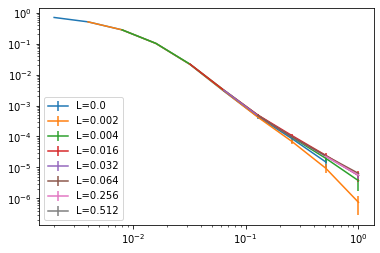

In [9]:
measurements.plot_expS_vs_L()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [10]:
Ms = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
Ls = [0.0, 0.002, 0.004, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0]
sf0 = "output_data/measurements_1x100_lmbd_0.01_v0_3.0_alpha_0.0_m_1.0_dt_0.2_bar_100.0_M_0.0_L_1.0_tfull_5_tFV_65_*_1-1.bin"
da_list = measurements.get_M_L_list(Ms, Ls, sf0)
ratio=measurements.calc_ratio(da_list, len(Ms)-1)
print(ratio)

AttributeError: 'Data' object has no attribute 'get_M_L_list'

In [17]:
blocks = jk.get_super_jackknife_blocks(da_list, 1000, lambda x: measurements.calc_ratio(x, len(Ms)-1))
jk.get_errors_from_blocks(ratio, blocks)

[0.0002653559844209393, 3.800391252415348e-05]

In [ ]:
[0.0002653559844209393, 3.800391252415348e-05]